## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [58]:
import os
os.environ["KERAS_BACKEND"] = "torch" # Needs to be set, some pruning layers as well as the quantizers are Keras
import keras
keras.config.set_backend("torch")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

In [59]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

resnet_mdmm_unstr_paca_pruned.pth
resnet_mdmm_unstr_pruned.pth
resnet_paca_pruned.pth
trained_models
pquant
data
smartpixels


In [60]:
SAVE_PATH = 'resnet_mdmm_unstr_pruned.pth'
# torch.save(model_copy.state_dict(), SAVE_PATH)

model = torchvision.models.resnet18()
model.load_state_dict(torch.load(SAVE_PATH))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/tmp/ipykernel_505000/842026278.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


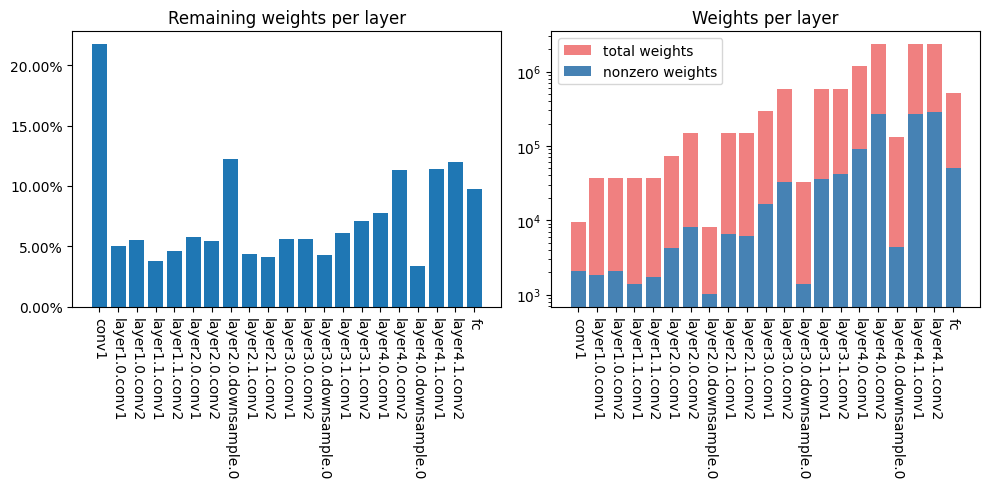

In [61]:
# Plot remaining weights
import numpy as np
import matplotlib.pyplot as plt

names = []
remaining = []
total_w = []
nonzeros = []
for n, m in model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100:.2f}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from keras import ops


def plot_pattern_distributions(counts, dominant_patterns, layer_name = "conv1", log_scale1 = False, log_scale2 = False):
    counts_np  = ops.convert_to_numpy(counts)                # (U,)
    order      = np.argsort(-counts_np)                      # descending freq
    sorted_cnt = counts_np[order]

    n_keep     = dominant_patterns.shape[0]                  # M  <= alpha

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(np.arange(sorted_cnt.size), sorted_cnt, linewidth=0)
    if log_scale1: ax1.set_yscale("log")
    ax1.set_xlabel("Pattern rank (frequency ↓)")
    ax1.set_ylabel("Count")
    ax1.set_title(f"Pattern distribution – {layer_name}")
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    ax1.axvline(n_keep - 0.5, color="red", linestyle="--",
                label=f"kept = {n_keep}")
    ax1.legend()
    fig1.tight_layout()

    dominant_cnt = sorted_cnt[:n_keep]

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.bar(np.arange(n_keep), dominant_cnt, color="tab:orange", linewidth=0)
    if log_scale2: ax2.set_yscale("log")
    ax2.set_xlabel("Dominant pattern index (0‥M‑1)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"Dominant patterns – {layer_name}")
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    fig2.tight_layout()

    plt.show()


In [63]:
import math

def plot_dominant_patterns(layer_name, dominant_patterns, dominant_counts, kH, kW, max_patterns_to_show=16):
    import math
    pats = ops.convert_to_numpy(dominant_patterns)
    cnts = ops.convert_to_numpy(dominant_counts)
    num_to_show = min(pats.shape[0], max_patterns_to_show)

    cols = math.ceil(math.sqrt(num_to_show))
    rows = math.ceil(num_to_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2.2))
    axes = np.array(axes).flatten()
    fig.suptitle(f"Dominant Patterns for Layer: {layer_name}", fontsize=16)

    for i in range(num_to_show):
        pattern_2d = pats[i].reshape(kH, kW)
        axes[i].imshow(pattern_2d, cmap='binary', vmin=0, vmax=1, interpolation='nearest')
        axes[i].set_title(f"#{i+1} (Count: {int(cnts[i])})")
        axes[i].set_xticks([]); axes[i].set_yticks([])

    for j in range(num_to_show, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [64]:
from pquant.pruning_methods.utils import patterns

In [65]:
import torchvision.transforms as transforms
from tqdm import tqdm

def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

def evaluate_model(model, testloader, device):
    """
    Evaluates the model's accuracy on the provided data loader.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(testloader, desc="Evaluating Model", unit="batch", dynamic_ncols=True) as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                running_acc = 100. * correct / total
                pbar.set_postfix(acc=f"{running_acc:.2f}%")
    
    final_accuracy = 100. * correct / total
    print(f"Final Accuracy: {final_accuracy:.2f}%")
    return final_accuracy

In [111]:
BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [112]:
from keras import ops
import glob
import re

fingerprint = "18fe8243"
SAVE_DIR = f'/depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/{fingerprint}/unstr_paca/'
print(SAVE_DIR)
files = os.listdir(SAVE_DIR)

# Extract accuracy as float from filename and sort descending
files_sorted = sorted(
    files,
    key=lambda x: float(re.search(r"_a([0-9]+\.[0-9]+)", x).group(1)),
    reverse=True
)

for f in files_sorted:
    acc = float(re.search(r"_a([0-9]+\.[0-9]+)", f).group(1))
    if "BP" in f: print(f"{f}  -->  {acc}")
    
print()

for f in files_sorted:
    acc = float(re.search(r"_a([0-9]+\.[0-9]+)", f).group(1))
    if "AP" in f: print(f"{f}  -->  {acc}")

/depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/18fe8243/unstr_paca/
BP_e4_a84.71_r0.46.pt  -->  84.71
BP_clean_e4_a84.71_r0.46.pth  -->  84.71
BP_e2_a83.20_r0.46.pt  -->  83.2
BP_clean_e2_a83.20_r0.46.pth  -->  83.2
BP_clean_e3_a83.02_r0.46.pth  -->  83.02
BP_e3_a83.02_r0.46.pt  -->  83.02
BP_e1_a80.67_r0.46.pt  -->  80.67
BP_clean_e1_a80.67_r0.46.pth  -->  80.67
BP_clean_e0_a78.44_r0.46.pth  -->  78.44
BP_e0_a78.44_r0.46.pt  -->  78.44
BP_clean_e6_a70.75_r0.19.pth  -->  70.75
BP_e6_a70.75_r0.19.pt  -->  70.75
BP_e5_a65.73_r0.19.pt  -->  65.73
BP_clean_e5_a65.73_r0.19.pth  -->  65.73

AP_clean_e4_a84.71_r0.46.pth  -->  84.71
AP_e4_a84.71_r0.46.pt  -->  84.71
AP_e2_a83.20_r0.46.pt  -->  83.2
AP_clean_e2_a83.20_r0.46.pth  -->  83.2
AP_e3_a83.02_r0.46.pt  -->  83.02
AP_clean_e3_a83.02_r0.46.pth  -->  83.02
AP_clean_e1_a80.67_r0.46.pth  -->  80.67
AP_e1_a80.67_r0.46.pt  -->  80.67
AP_clean_e0_a78.44_r0.46.pth  -->  78.44
AP_e0_a78.44_r0.46.pt  -->  78.44
AP_e6_a70.75_r0.19.pt  -

In [113]:
def plot_pattern_distributions(unique_counts, dominant_counts,
                               layer_name="conv1",
                               log_scale1=False, log_scale2=False):
    """
    unique_counts: counts from _get_unique_patterns_with_counts (shape [U])
    dominant_counts: counts aligned to dominant_patterns (shape [M])
    """
    # Sort unique counts (desc) with keras.ops, convert once for plotting
    counts_f32 = ops.cast(unique_counts, "float32")
    order = ops.argsort(-counts_f32)               # [U]
    sorted_cnt = ops.take(counts_f32, order, axis=0)

    sorted_cnt_np = ops.convert_to_numpy(sorted_cnt)
    M = int(ops.convert_to_numpy(ops.shape(dominant_counts)[0]))
    dom_cnt_np = ops.convert_to_numpy(ops.cast(dominant_counts, "float32"))

    # --- Plot full distribution over unique patterns ---
    fig1, ax1 = plt.subplots(figsize=(8, 5))
    ax1.bar(np.arange(sorted_cnt_np.size), sorted_cnt_np, linewidth=0)
    if log_scale1: ax1.set_yscale("log")
    ax1.set_xlabel("Pattern rank (frequency ↓)")
    ax1.set_ylabel("Count")
    ax1.set_title(f"Pattern distribution - {layer_name}")
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    ax1.axvline(M - 0.5, color="red", linestyle="--", label=f"kept = {M}")
    ax1.legend()
    fig1.tight_layout()

    # --- Plot only the kept (dominant) patterns ---
    fig2, ax2 = plt.subplots(figsize=(6, 4))
    ax2.bar(np.arange(M), dom_cnt_np, linewidth=0)
    if log_scale2: ax2.set_yscale("log")
    ax2.set_xlabel("Dominant pattern index (0‥M-1)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"Dominant patterns - {layer_name}")
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    fig2.tight_layout()

    plt.show()



In [114]:
def dominant_or(a, b):
    a = ops.cast(ops.not_equal(a, 0), "bool")
    b = ops.cast(ops.not_equal(b, 0), "bool")
    out = ops.logical_or(a, ops.logical_not(b))
    return out

def pat_in_dom(patterns, dominant_patterns):
    p = ops.cast(ops.not_equal(patterns, 0), "bool")
    d = ops.cast(ops.not_equal(dominant_patterns, 0), "bool")
    ok_bits = dominant_or(ops.expand_dims(d, 0), ops.expand_dims(p, 1))  # [N,M,K]
    return ops.all(ok_bits, axis=-1)

def pat_in_any_dom(patterns, dominant_patterns):
    fits = pat_in_dom(patterns, dominant_patterns)  # [N,M]
    return ops.any(fits, axis=1)

def all_pat_in_any_dom(patterns, dominant_patterns):
    covered = pat_in_any_dom(patterns, dominant_patterns)  # [N]
    return ops.all(covered, axis=0)

a = np.array([  # dominants (M=4)
    [0,0,1,1,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [1,1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0],
], dtype=np.float32)

b = np.array([  # patterns (N=3)
    [1,1,1,1,1,1,1,1,1],  # not subset of any
    [0,0,1,1,1,0,0,0,0],  # matches a[0]
    [0,0,0,0,0,0,0,0,0],  # matches all
    [0,0,0,1,0,0,0,0,0],
], dtype=np.float32)

fits_any = pat_in_any_dom(b, a)         # [True/False per pattern]
print(ops.convert_to_numpy(fits_any))   

fits_all = all_pat_in_any_dom(b, a)     # [True/False]
print(ops.convert_to_numpy(fits_all))


[False  True  True  True]
False


In [115]:

pattern = "BP_clean_e1_*"  

matches = glob.glob(os.path.join(SAVE_DIR, pattern))
if not matches:
    raise FileNotFoundError(f"No files matching {pattern} in {SAVE_DIR}")
if len(matches) > 1:
    print(f"Multiple matches found: {matches}")
    
SAVE_PATH = matches[0]
print("Loading:", SAVE_PATH)

model_paca = torchvision.models.resnet18()
state_dict = torch.load(SAVE_PATH)
model_paca.load_state_dict(state_dict)
model_paca = model_paca.to(device)


for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)
    dominant_counts = patterns.count_dominant_patterns(dominant_patterns, unique_patterns, counts)

    apm = all_pat_in_any_dom(unique_patterns, dominant_patterns)
    print(bool(ops.convert_to_numpy(apm)))

Loading: /depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/18fe8243/unstr_paca/BP_clean_e1_a80.67_r0.46.pth
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
False
False


In [116]:

pattern = "AP_e7_*"  

matches = glob.glob(os.path.join(SAVE_DIR, pattern))
if not matches:
    raise FileNotFoundError(f"No files matching {pattern} in {SAVE_DIR}")
if len(matches) > 1:
    print(f"Multiple matches found: {matches}")
    
SAVE_PATH = matches[0]
print("Loading:", SAVE_PATH)

model_paca = torchvision.models.resnet18()
state_dict = torch.load(SAVE_PATH)
model_paca.load_state_dict(state_dict)
model_paca = model_paca.to(device)


for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)
    dominant_counts = patterns.count_dominant_patterns(dominant_patterns, unique_patterns, counts)

    apm = all_pat_in_any_dom(unique_patterns, dominant_patterns)
    print(bool(ops.convert_to_numpy(apm)))

FileNotFoundError: No files matching AP_e7_* in /depot/cms/users/das214/PQuant/trained_models/resnet/mdmm/18fe8243/unstr_paca/

In [ ]:

pattern = "BP_clean_e6_*"  

matches = glob.glob(os.path.join(SAVE_DIR, pattern))
if not matches:
    raise FileNotFoundError(f"No files matching {pattern} in {SAVE_DIR}")
if len(matches) > 1:
    print(f"Multiple matches found: {matches}")
    
SAVE_PATH = matches[0]
print("Loading:", SAVE_PATH)

model_paca = torchvision.models.resnet18()
state_dict = torch.load(SAVE_PATH)
model_paca.load_state_dict(state_dict)
model_paca = model_paca.to(device)


Loading: trained_models/resnet/mdmm/18fe8243/unstr_paca/BP_clean_e6_a71.72_r0.19.pth


In [ ]:
for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)
    dominant_counts = patterns.count_dominant_patterns(dominant_patterns, unique_patterns, counts)

    apm = all_pat_in_any_dom(unique_patterns, dominant_patterns)
    print(bool(ops.convert_to_numpy(apm)))
    # print(name, len(dominant_patterns))
    # print(dominant_patterns.shape)
    # print()
    # plot_pattern_distributions(counts, dominant_counts, layer_name=name,
    #                            log_scale1=False, log_scale2=True)
    # try: plot_dominant_patterns(name, dominant_patterns, dominant_counts, 
    #                             kH, kW, max_patterns_to_show=16)
    # except: pass
    
    # break

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
False
False


In [ ]:
distance_metric = 'valued_hamming'
for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    weight = module.weight
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, 
                                                           counts, alpha = 16, beta = 0.85, 
                                                           dtype=module.weight.dtype)

    _, distances = patterns._pattern_distances(weight, dominant_patterns, distance_metric = distance_metric) # Shape: (C_out*C_in, num_dominant)
    print(f"Mean Distances (BP): {ops.mean(ops.min(distances, axis=1)).item():0.2f}")


Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00
Mean Distances (BP): 0.00


In [117]:
evaluate_model(model_paca, val_loader, device)

Evaluating Model: 100%|██████████| 196/196 [00:02<00:00, 79.79batch/s, acc=82.78%]

Final Accuracy: 82.78%


82.78

In [118]:
def apply_projection_mask(model, alpha=16, beta=0.85):
    """
    Modifies the model's convolutional weights in-place by projecting them
    onto the nearest dominant sparsity patterns.
    """
    print("\nApplying projection mask to model weights...")
    # Use torch.no_grad() to ensure gradients are not computed for this manual operation
    with torch.no_grad():
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                weight = module.weight
                
                # 1. Find dominant patterns in the current weight tensor
                _, all_patterns, _= patterns._get_kernels_and_patterns(weight)
                unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
                
                # Skip if there are no patterns to analyze
                if ops.shape(unique_patterns)[0] == 0:
                    print(f"  - Skipping {name}: No non-zero patterns found.")
                    continue
                    
                dominant_patterns = patterns._select_dominant_patterns(all_patterns, 
                                                              unique_patterns, counts,
                                                              alpha=alpha, beta=beta, dtype=weight.dtype)

                # 2. Calculate the projection mask by finding the closest dominant pattern for each kernel
                projection_mask_keras = patterns._get_projection_mask(weight,dominant_patterns, 
                                                                      src="OIHW", epsilon=1e-5, distance_metric='cosine')

                
                # 3. Convert Keras tensor back to PyTorch tensor and move to the correct device
                projection_mask_torch = ops.convert_to_tensor(projection_mask_keras, dtype=weight.dtype)
                projection_mask_torch = projection_mask_torch.to(weight.device)

                # 4. Apply the mask to the weight tensor IN-PLACE
                module.weight.data *= projection_mask_torch
                print(f"  - Applied mask to layer: {name} with {len(dominant_patterns)} dominant patterns.")
                print(f"\t {len(unique_patterns)} unique patterns before projection.")
                _, all_patterns_projection_mask, _ = patterns._get_kernels_and_patterns(projection_mask_keras)
                unique_projection_patterns, _ = patterns._get_unique_patterns_with_counts(all_patterns_projection_mask)   
     
                print(f"\t {len(unique_projection_patterns)} unique patterns after projection.")
    print("Weight modification complete.")

In [119]:
apply_projection_mask(model_paca, alpha=16, beta=0.85)


Applying projection mask to model weights...
  - Applied mask to layer: conv1 with 6 dominant patterns.
	 31 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer1.0.conv1 with 1 dominant patterns.
	 35 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer1.0.conv2 with 1 dominant patterns.
	 28 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer1.1.conv1 with 1 dominant patterns.
	 34 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer1.1.conv2 with 1 dominant patterns.
	 25 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer2.0.conv1 with 1 dominant patterns.
	 31 unique patterns before projection.
	 1 unique patterns after projection.
  - Applied mask to layer: layer2.0.conv2 with 1 dominant patterns.
	 38 unique pattern

In [120]:
for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)
    dominant_counts = patterns.count_dominant_patterns(dominant_patterns, unique_patterns, counts)

    apm = all_pat_in_any_dom(unique_patterns, dominant_patterns)
    print(bool(ops.convert_to_numpy(apm)))


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [121]:
distance_metric = 'valued_hamming'
for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    weight = module.weight
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, 
                                                           counts, alpha = 16, beta = 0.85, 
                                                           dtype=module.weight.dtype)

    _, distances = patterns._pattern_distances(weight, dominant_patterns, distance_metric = distance_metric) # Shape: (C_out*C_in, num_dominant)
    print("Mean Distances (BP):", ops.mean(ops.min(distances, axis=1)).item())
    # closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
    # projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
    # projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))
    
    # projected_weights = weight * projection_mask 
    # _, distances = patterns._pattern_distances(projected_weights, dominant_patterns, distance_metric = distance_metric) # Shape: (C_out*C_in, num_dominant)
    # print("Mean Distances (AP):", ops.mean(ops.min(distances, axis=1)).numpy().item())
    
    # _, all_patterns_projection_mask, _ = patterns._get_kernels_and_patterns(projection_mask)
    # unique_projection_patterns, _ = patterns._get_unique_patterns_with_counts(all_patterns_projection_mask)   
                                  


Mean Distances (BP): 0.0002580548170953989
Mean Distances (BP): 0.00012078264990122989
Mean Distances (BP): 8.220285235438496e-05
Mean Distances (BP): 0.00014905346324667335
Mean Distances (BP): 8.40670763864182e-05
Mean Distances (BP): 8.721982885617763e-05
Mean Distances (BP): 8.619225263828412e-05
Mean Distances (BP): 1.0243486485705944e-06
Mean Distances (BP): 0.00013203184062149376
Mean Distances (BP): 0.0001245677995029837
Mean Distances (BP): 0.00014328108227346092
Mean Distances (BP): 0.00016682024579495192
Mean Distances (BP): 3.4946071991726058e-06
Mean Distances (BP): 0.00017009943258017302
Mean Distances (BP): 0.0001942484814208001
Mean Distances (BP): 5.3276387916412205e-05
Mean Distances (BP): 0.001193877193145454
Mean Distances (BP): 6.45074305793969e-06
Mean Distances (BP): 0.0009402798023074865
Mean Distances (BP): 0.0009844743181020021


In [122]:
evaluate_model(model_paca, val_loader, device)

Evaluating Model: 100%|██████████| 196/196 [00:04<00:00, 44.42batch/s, acc=82.78%]

Final Accuracy: 82.78%


82.78

In [ ]:
for name, module in model_paca.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)
    dominant_counts = patterns.count_dominant_patterns(dominant_patterns, unique_patterns, counts)

    apm = all_pat_in_any_dom(unique_patterns, dominant_patterns)
    print(name, len(dominant_patterns))
    print(dominant_patterns.shape)
    print()
    plot_pattern_distributions(counts, dominant_counts, layer_name=name,
                               log_scale1=False, log_scale2=True)
    try: plot_dominant_patterns(name, dominant_patterns, dominant_counts, 
                                kH, kW, max_patterns_to_show=16)
    except: pass
    
    break

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16,) and arg 1 with shape (16, 49).

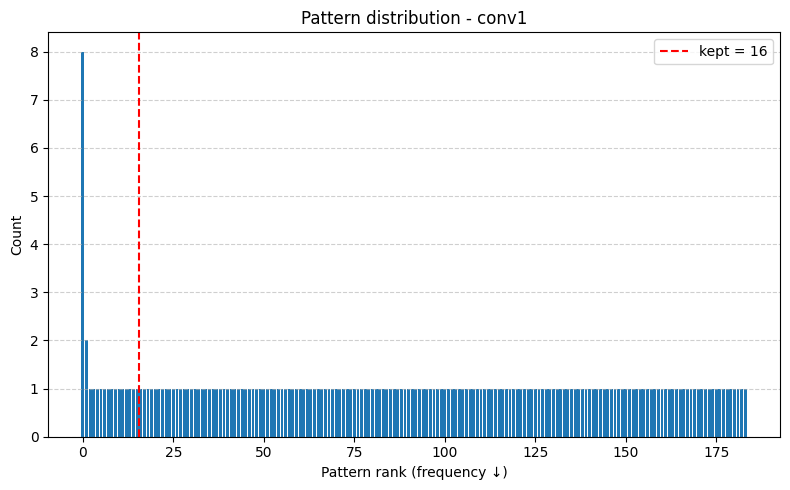

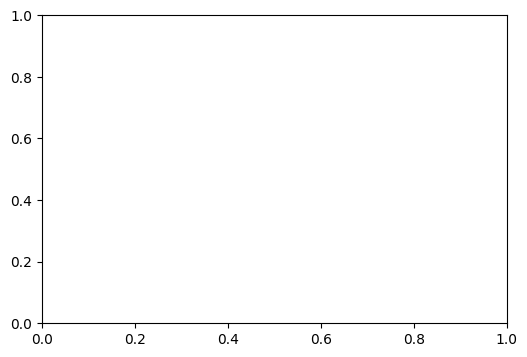

In [123]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    kernels, all_patterns, (C_out, C_in, kH, kW) =patterns._get_kernels_and_patterns(module.weight)
    unique_patterns, counts = patterns._get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = patterns._select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = False, log_scale2 = False)
    try: plot_dominant_patterns(name, all_patterns, counts, kH, kW, max_patterns_to_show=16)
    except: pass
    
    break

In [100]:
dominant_patterns.shape

torch.Size([16, 49])

In [101]:
print(counts)
print(len(unique_patterns))

tensor([8, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0',
       dtype=torch.int32)
184


In [102]:
for name, module in model.named_modules():
    if not isinstance(module, torch.nn.Conv2d):
        continue
    
    weight = module.weight
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(module.weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.99, dtype=module.weight.dtype)

    _, distances = _pattern_distances(dominant_patterns, weight) # Shape: (C_out*C_in, num_dominant)
    closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
    projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
    projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))
    
    projected_weight = (weight.cpu() + 1.0e-5)* projection_mask.cpu()
    
    print(name, len(dominant_patterns))
    print(dominant_patterns.shape)
    print(unique_patterns.shape)
    print()

    weight = projected_weight
    kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(weight)
    unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
    # dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

    # print(name, len(dominant_patterns))
    # print(dominant_patterns.shape)
    print(unique_patterns.shape)
    print()
    
    # plot_pattern_distributions(counts, dominant_patterns, layer_name = name, log_scale1 = False, log_scale2 = False)
    # try: plot_dominant_patterns(name, all_patterns, counts, kH, kW, max_patterns_to_show=16)
    # except: pass
    
    # break

conv1 16
torch.Size([16, 49])
torch.Size([184, 49])

torch.Size([16, 49])

layer1.0.conv1 16
torch.Size([16, 9])
torch.Size([178, 9])

torch.Size([16, 9])

layer1.0.conv2 16
torch.Size([16, 9])
torch.Size([188, 9])

torch.Size([16, 9])

layer1.1.conv1 16
torch.Size([16, 9])
torch.Size([161, 9])

torch.Size([15, 9])

layer1.1.conv2 16
torch.Size([16, 9])
torch.Size([147, 9])

torch.Size([15, 9])

layer2.0.conv1 16
torch.Size([16, 9])
torch.Size([281, 9])

torch.Size([16, 9])

layer2.0.conv2 16
torch.Size([16, 9])
torch.Size([323, 9])

torch.Size([16, 9])

layer2.0.downsample.0 2
torch.Size([2, 1])
torch.Size([2, 1])

torch.Size([2, 1])

layer2.1.conv1 16
torch.Size([16, 9])
torch.Size([311, 9])

torch.Size([16, 9])

layer2.1.conv2 16
torch.Size([16, 9])
torch.Size([313, 9])

torch.Size([16, 9])

layer3.0.conv1 16
torch.Size([16, 9])
torch.Size([390, 9])

torch.Size([16, 9])

layer3.0.conv2 16
torch.Size([16, 9])
torch.Size([160, 9])

torch.Size([16, 9])

layer3.0.downsample.0 2
torch.Si

In [103]:
weight = module.weight
_, distances = _pattern_distances(dominant_patterns, weight) # Shape: (C_out*C_in, num_dominant)
closest_pattern_indices = ops.argmin(distances, axis=1) # Shape: (C_out*C_in,)
projection_mask_flat = ops.take(dominant_patterns, closest_pattern_indices, axis=0)
projection_mask = ops.reshape(projection_mask_flat, (C_out, C_in, kH, kW))

projected_weight = (weight.cpu() + 1.0e-5)* projection_mask.cpu()

ValueError: not enough values to unpack (expected 4, got 2)

In [67]:
weight = projected_weight
kernels, all_patterns, (C_out, C_in, kH, kW) =_get_kernels_and_patterns(weight)
unique_patterns, counts = _get_unique_patterns_with_counts(all_patterns)
dominant_patterns = _select_dominant_patterns(all_patterns, unique_patterns, counts, alpha = 16, beta = 0.75, dtype=module.weight.dtype)

print(counts)
print(len(unique_patterns))

tensor([ 30,  23,   4,  29, 106], device='cuda:0', dtype=torch.int32)
5


In [22]:
projected_weight[1]

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  3.8388e-01,
           1.0000e-05,  0.0000e+00],
         [-6.1947e-02,  0.0000e+00,  0.0000e+00, -0.0000e+00,  1.9032e-01,
           1.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  7.2474e-02,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0